In [1]:
import tifffile as tif
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2

Put data paths here:

In [22]:
path_img = "W:/Neurophysiology-Storage1/Wahl/Matteo/07_12_2020/MRR/left_forelimb_1.tif"
path_params = "W:/Neurophysiology-Storage1/Wahl/Matteo/07_12_2020/MRR/MRR_leftforelimb_Sensory_SensoryMapping1.json"

print("Loading data...")
img_stack = tif.imread(path_img)
f = open(path_params, 'r')
data_json = json.load(f)
f.close()
print("Done!")

Extract frame timestamps:

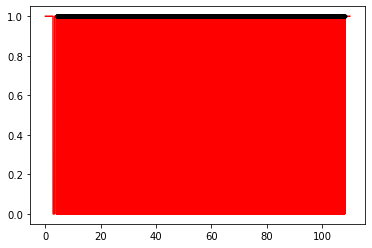

2082 frame timestamps from widefield identified! diff 0.050011 seconds (std 0.000080 s) equivalent to 19.995772 fps
number of frames in widefield: 2082 at 512x512 resolution


In [24]:
data_sync = data_json["Synchronisation"]
t_sample = data_sync[:,0]   #change this to data_sync[:,0] when using data from sensory_mapping_v2.vi
widefield = data_sync[:,1]  #change this to data_sync[:,1] when using data from sensory_mapping_v2.vi

# convert trigger trace to nice square wave
widefield_thresh = (widefield > 1.5).astype(np.float64)
diff = np.diff(widefield_thresh)

# identify frame timestamps, by averaging timestamps when camera has active exposure
frames = []
sequence = []
for i in range(len(t_sample[1:])):
    if diff[i] == -1:
        sequence = np.array(sequence)
        frames.append(np.mean(sequence[sequence!=0]))
        sequence = []
    sequence.append(widefield_thresh[1:][i]*t_sample[1:][i])

# discard first 2 "frames", which are due to camera starting up, not actual data acquisition    
frames_widefield = np.array(frames[2:])
plt.figure()
plt.plot(t_sample, widefield_thresh, 'r-')
plt.plot(frames_widefield, np.ones(len(frames_widefield)), 'k.')
plt.show()
print("%i frame timestamps from widefield identified!" % len(frames_widefield), end=' ')
print("diff %f seconds (std %f s) equivalent to %f fps" % (np.mean(np.diff(frames_widefield)), np.std(np.diff(frames_widefield)), 1/np.mean(np.diff(frames_widefield))))
print("number of frames in widefield: %i at %ix%i resolution" % (img_stack.shape[0], img_stack.shape[1], img_stack.shape[2]))

fps = round(1/np.mean(np.diff(frames_widefield)))

Compute DF/F of imgages around stimuli onsets:

In [25]:
# determine stimulus type
stim_type = data_json['Stimulus Type']
print("Stim type is %s." % stim_type)

if stim_type == "Visual":
    stim_timestamps = data_json['Visual Timestamps']
elif stim_type == "Sensory":
    stim_timestamps = data_json['Sensory Timestamps']
elif stim_type == "Auditory":
    stim_timestamps == data_json['Auditory Timestamps']
else:
    raise ValueError("Stim type not recognized!")
    
# make list of DF_F images in +/- 2s range from stim onset
pre_stim = data_json['Pre_stim (s)']
stim_len = data_json['Stimulus Duration (s)']
post_stim = data_json['Post_stim (s)']

frames_pre = int(pre_stim * fps)
frames_stim = int(stim_len * fps)
frames_post = int(post_stim * fps)

DF_F = []

for i in range(len(stim_timestamps)):
    t_onset = stim_timestamps[i]
    frame_onset = np.argwhere(frames_widefield>t_onset)[0][0]
    print("%i/%i, frame %i" % (i+1, len(stim_timestamps), frame_onset))
    before = img_stack[frame_onset-frames_pre:frame_onset,:,:]
    F = np.mean(before, axis=0)
    DF_F.append((img_stack[frame_onset-frames_pre:frame_onset+frames_stim+frames_post, :,:]-F)/F)

Stim type is Sensory.
119
319


C:\Users\mpanze\Anaconda3\envs\opencv_2\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


519
719
919
1119
1319
1519
1719
1919


Compute and plot average DF_F:

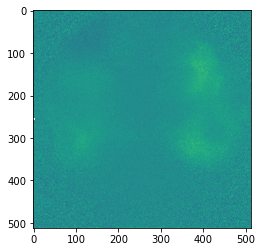

In [26]:
stim_area = data_json["Stimulated brain region"]

img_avg_pre = np.zeros((512,512), dtype=np.float64)
img_avg_stim = np.zeros((512,512), dtype=np.float64)
img_avg_post = np.zeros((512,512), dtype=np.float64)
for i in range(len(DF_F)):
    img_avg_pre += np.mean(DF_F[i][:frames_pre, :, :], axis=0)
    img_avg_stim += np.mean(DF_F[i][frames_pre:frames_pre+frames_stim, :, :], axis=0)
    img_avg_post += np.mean(DF_F[i][frames_pre+frames_stim:frames_pre+frames_stim+frames_post, :, :], axis=0)
img_avg = img_avg/len(DF_F)

plt.figure(figsize=(3, 2), dpi=300)
plt.title("%s pre" % (stim_area))
plt.imshow(img_avg_pre)
plt.colorbar()

plt.figure(figsize=(3, 2), dpi=300)
plt.title("%s stim" % (stim_area))
plt.imshow(img_avg_stim)
plt.colorbar()

plt.figure(figsize=(3, 2), dpi=300)
plt.title("%s post" % (stim_area))
plt.imshow(img_avg_post)
plt.colorbar()

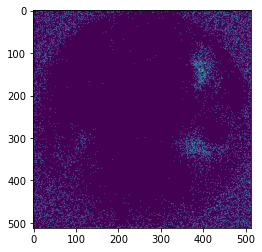

In [27]:
p = np.percentile(img_avg_sim.flatten(), 95)
plt.figure(figsize=(3, 2), dpi=300)
plt.imshow(img_avg_stim>p)